In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from tools.e5tools import *;from tools.generalTools import *
from tools.generalTools import qsat
SCRATCH='/global/cscratch1/sd/qnicolas/'

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

In [2]:
xr.set_options(display_style='text') 

# Functions, data

In [3]:
def extract_wrfout(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)
def extract_wrfpro(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfpout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)

In [4]:
hrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')
hrchannel_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')
hrchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.days0-200.nc')
hrchannel_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d

In [5]:
dryhrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/')

In [6]:
hrhgt = hrchannel.HGT.isel(south_north=0,Time=-1).persist()
hrdist=(1635-hrhgt.west_east)*3
def plotsection(hgt,figsize=(15,4)):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.set_xlabel("distance west of mountain top (km)")
    ax.set_ylabel("height(m)")
    ax.plot((1635-hgt.west_east)*3,hgt,color='k')
    return ax,ax.twinx()

def f(x):
    return np.sign(x)*x**2

def change_coords_eta(sim,w,center=1635,staggered=0):
    if staggered:
        return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()
    else:
        return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'eta_level':sim.ZNU.isel(Time=-1),'pressure':sim.PB[-1,:,0,:].load()/100}).swap_dims({'bottom_top':'eta_level','west_east':'distance_from_mtn'}).persist()

def change_coords_etav(sim,w,staggered=0):
    if staggered:
        return w.assign_coords({'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level'}).persist()
    else:
        return w.assign_coords({'eta_level':sim.ZNU.isel(Time=-1),'pressure':sim.PB[-1,:,0,:].load()/100}).swap_dims({'bottom_top':'eta_level'}).persist()

def change_coords_pl(sim,w,center=1635):
    return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'pressure':sim.P_PL[0]/100}).swap_dims({'num_press_levels_stag':'pressure','west_east':'distance_from_mtn'}).persist()

def change_coords_press(sim,w):
    return w.assign_coords({'pressure':sim.P_PL[0]/100}).swap_dims({'num_press_levels_stag':'pressure'})

def change_coords_sfc(w,center=1635):
    return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3}).swap_dims({'west_east':'distance_from_mtn'}).persist()


In [7]:
def pressure_delta(column,pressure) :
    """given two arrays of the same length, return the pressure range corresponding to the non-nan values of column.
    e.g. if column = [nan,a,b,c,nan,nan] and pressure=[p1,p2,p3,p4,p5,p6], return p4-p2.
    Doesn't work if there are nans in the middle, eg. column = [nan,a,nan,c,nan,nan] (would still return p4-p2)"""
    
    idxs = np.where(~np.isnan(column))[0]
    try :
        return np.abs(pressure[idxs[-1]]-pressure[idxs[0]])
    except IndexError :
        print("Column only contains nans")
        return np.nan
def pressure_mean(da,vdim='pressure'):
    da_integ = da.fillna(0.).integrate(vdim)
    weights = xr.apply_ufunc(pressure_delta,da,da.pressure,input_core_dims=[[vdim],[vdim]],vectorize=True)#,dask="parallelized",output_dtypes=float)
    return da_integ/weights

In [8]:
def interp_eta_to_pressure(ds,var,staggered=1,plevs=None):
    """Make sure eta_level is the first dimension"""
    if plevs is None:
        plevs= np.arange(125.,990.,20.)
    rep=np.zeros((len(plevs),len(var[0])))
    PB_rev = np.array(ds.PB[0,:,0])[::-1]
    var_rev=np.array(var)[::-1]
    if staggered:
        i=0
        ZNW = np.array(ds.ZNW[0])[::-1]
        ZNU=  np.array(ds.ZNU[0])[::-1]
        for i in range(len(var[0])):
            PB_rev_stag = np.interp(ZNW,ZNU,PB_rev[:,i])
            rep[:,i]=np.interp(plevs*100,PB_rev_stag,var_rev[:,i])
            rep[plevs*100>PB_rev_stag[-1],i]=np.nan
    else:
        for i in range(len(var[0])):
            rep[:,i]=np.interp(plevs*100,PB_rev[:,i],var_rev[:,i])
            rep[plevs*100>PB_rev[-1,i],i]=np.nan
    return xr.DataArray(rep[::-1],coords={'pressure':plevs[::-1],'distance_from_mtn':var.distance_from_mtn},dims=['pressure','distance_from_mtn'])

In [9]:
import wrf
from netCDF4 import Dataset,MFDataset
def interp_pressure(var):
    """Interp a 3D var (no time dependence) from eta levels to pressure levels. var must be destaggered"""
    plevs=np.array(hrchannel_p.P_PL.isel(Time=0).load())[1:-4]/100
    return wrf.vinterp(Dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/wrfout_d01_1970-02-20_06_00_00'),
                         var,"pressure",plevs
                        ).rename({'interp_level':'pressure'}).fillna(0.)

In [10]:
from scipy.interpolate import interp1d
def interp_pressure2(ds,var,plevs=None):
    """Interp a 4D var from eta levels to pressure levels. var must be destaggered"""
    if plevs is None:
        plevs=np.array(hrchannel_p.P_PL.isel(Time=0).load())[1:-4][::-1]/100
    rep=np.zeros((len(var.Time),len(plevs),len(var.south_north),len(var.west_east)))
    PB_rev = np.array(ds.PB[0,:,0])[::-1]
    var_rev=np.array(var)[:,::-1]
    for k in range(len(var.west_east)):
        rep[:,:,:,k]=interp1d(PB_rev[:,k], var_rev[:,:,:,k], kind='linear', axis=1,fill_value='extrapolate', assume_sorted=True)(plevs*100)

    return xr.DataArray(rep[:,::-1],coords={'Time':var.Time,'pressure':plevs[::-1],'south_north':var.south_north,'west_east':var.west_east},dims=['Time','pressure','south_north','west_east'])

In [11]:
umean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.U_PL.days50-200.nc')
wmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W_PL.days50-200.nc')
rhomean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO_PL.days50-200.nc')
qmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.Q_PL.days50-200.nc')
tmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.T_PL.days50-200.nc')

umean = umean.where(umean >-30.)  
wmean   = wmean.where(wmean > -10)  
rhomean = rhomean.where(rhomean >0.)  
qmean   = qmean.where(qmean >0.)  
tmean   = tmean.where(tmean >100.)  
omegamean = -9.81*rhomean*wmean

umean_p = change_coords_pl(hrchannel_p,umean)[5:-4]
qmean_p =     change_coords_pl(hrchannel_p,qmean)[5:-4]
tmean_p =     change_coords_pl(hrchannel_p,tmean)[5:-4]
omegamean_p = change_coords_pl(hrchannel_p,omegamean)[5:-4]
thetamean_p = (tmean_p*(tmean_p.pressure/1e3)**(-0.286))


In [12]:
dryumean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.U_PL.days50-100.nc')[::-1]
drywmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.W_PL.days50-100.nc')[::-1]
dryrhomean = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.RHO_PL.days50-100.nc')[::-1]
drytmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.T_PL.days50-100.nc')[::-1]

dryumean     = dryumean.where(dryumean >-30.)  
drywmean     = drywmean.where(drywmean > -10)  
dryrhomean   = dryrhomean.where(dryrhomean >0.)  
drytmean     = drytmean.where(drytmean >100.)  
dryomegamean = -9.81*dryrhomean*drywmean

dryumean_p     = change_coords_sfc(dryumean)[4:]
drytmean_p     = change_coords_sfc(drytmean)[4:]
dryomegamean_p = change_coords_sfc(dryomegamean)[4:]
drythetamean_p = (drytmean_p*(drytmean_p.pressure/1e3)**(-0.286))

In [13]:
umean_s     = change_coords_eta(hrchannel,wrf.destagger(xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.U.days50-200.nc'),1,meta=True))
wmean_s     = change_coords_eta(hrchannel,wrf.destagger(xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W.days50-200.nc'),0,meta=True)     )
rhomean_s   = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.RHO.days50-200.nc')   )
qmean_s     = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.QVAPOR.days50-200.nc'))
tmean_s     = change_coords_eta(hrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.TEMP.days50-200.nc')  )
omegamean_s = -9.81*rhomean_s*wmean_s

In [14]:
dryumean_s   = change_coords_eta(dryhrchannel,wrf.destagger(xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.U.days50-100.nc'),1,meta=True))
drywmean_s   = change_coords_eta(dryhrchannel,wrf.destagger(xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.W.days50-100.nc'),0,meta=True))
dryrhomean_s = change_coords_eta(dryhrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.RHO.days50-100.nc')   )
dryqmean_s   = change_coords_eta(dryhrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.QVAPOR.days50-100.nc'))
drytmean_s   = change_coords_eta(dryhrchannel,xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.TEMP.days50-100.nc')  )
dryomegamean_s = -9.81*dryrhomean_s*drywmean_s

In [15]:
plevs_875 = np.array(umean_p.pressure[::-1])
DeltaP=125-875

In [16]:

umean_sp     = interp_eta_to_pressure(hrchannel,umean_s  ,staggered=0,plevs=plevs_875)
qmean_sp     = interp_eta_to_pressure(hrchannel,qmean_s,staggered=0,plevs=plevs_875)
tmean_sp     = interp_eta_to_pressure(hrchannel,tmean_s  ,staggered=0,plevs=plevs_875)
omegamean_sp = interp_eta_to_pressure(hrchannel,omegamean_s  ,staggered=0,plevs=plevs_875)
dryumean_sp     = interp_eta_to_pressure(dryhrchannel,dryumean_s  ,staggered=0,plevs=plevs_875)
dryqmean_sp     = interp_eta_to_pressure(dryhrchannel,dryqmean_s,staggered=0,plevs=plevs_875)
drytmean_sp     = interp_eta_to_pressure(dryhrchannel,drytmean_s  ,staggered=0,plevs=plevs_875)
dryomegamean_sp = interp_eta_to_pressure(dryhrchannel,dryomegamean_s  ,staggered=0,plevs=plevs_875)
thetamean_sp = (tmean_sp*(tmean_sp.pressure/1e3)**(-0.286))
drythetamean_sp = (drytmean_sp*(drytmean_sp.pressure/1e3)**(-0.286))

# Starting with T&SN mean variables, computing terms, averaging spatially

In [18]:
dryudthetadx = -(dryumean_sp*drythetamean_sp.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
dryomegadthetadp = (dryomegamean_sp*drythetamean_sp.differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP

udthetadx = -(umean_sp*thetamean_sp.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
omegadthetadp = (omegamean_sp*thetamean_sp.differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP
Qdiab_pi = udthetadx+omegadthetadp


In [29]:
dryudthetadx_p = -(dryumean_p*drythetamean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
dryomegadthetadp_p = (dryomegamean_p*drythetamean_p.differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP

udthetadx_p = -(umean_p*thetamean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
omegadthetadp_p = (omegamean_p*thetamean_p.differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP
Qdiab_pi_p = udthetadx_p+omegadthetadp_p

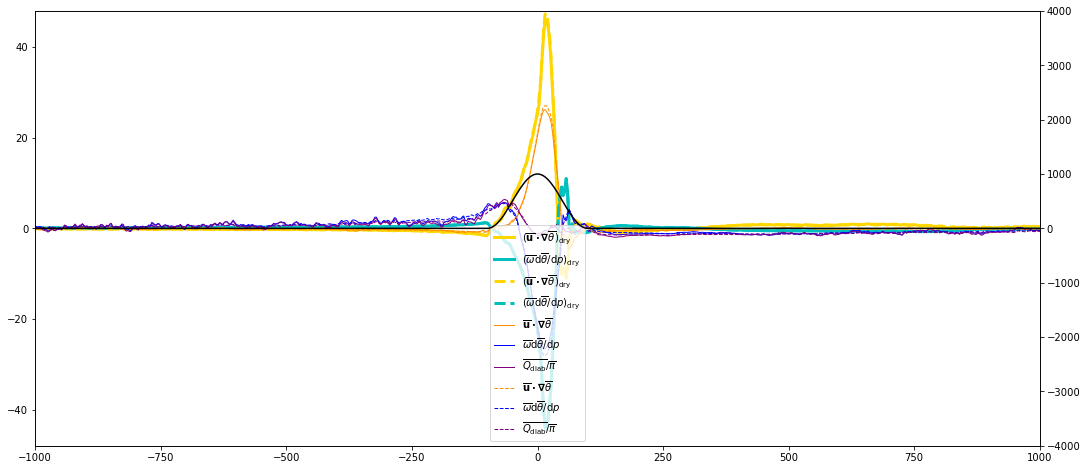

In [31]:
fig, ax = plt.subplots(1,1,figsize=(18,8))
ax2=ax.twinx()
ax2.plot(hrdist,hrhgt,color='k')

ax.plot(hrdist, dryudthetadx,linewidth=3,label=r"$(\mathbf{\overline{u} \cdot \nabla } \overline{\theta})_\mathrm{dry}$"     ,color="gold")
ax.plot(hrdist, dryomegadthetadp,linewidth=3,label=r"$(\overline{\omega} \mathrm{d}\overline{\theta}/\mathrm{d}p)_\mathrm{dry} $",color="c")

ax.plot(hrdist, dryudthetadx_p,linewidth=3,label=r"$(\mathbf{\overline{u} \cdot \nabla } \overline{\theta})_\mathrm{dry}$"         ,linestyle='--',color="gold")
ax.plot(hrdist, dryomegadthetadp_p,linewidth=3,label=r"$(\overline{\omega} \mathrm{d}\overline{\theta}/\mathrm{d}p)_\mathrm{dry} $",linestyle='--',color="c")


ax.plot(hrdist, udthetadx   ,linewidth=1,label=r"$\mathbf{\overline{u} \cdot \nabla } \overline{\theta}$"     , color="darkorange")
ax.plot(hrdist, omegadthetadp,linewidth=1,label=r"$\overline{\omega} \mathrm{d}\overline{\theta}/\mathrm{d}p $", color="b")
ax.plot(hrdist, Qdiab_pi     ,linewidth=1,label=r"$\overline{Q_\mathrm{diab}}/\overline{\pi}$", color="purple")

ax.plot(hrdist, udthetadx_p   ,linewidth=1,label=r"$\mathbf{\overline{u} \cdot \nabla } \overline{\theta}$"       ,linestyle='--', color="darkorange")
ax.plot(hrdist, omegadthetadp_p,linewidth=1,label=r"$\overline{\omega} \mathrm{d}\overline{\theta}/\mathrm{d}p $",linestyle='--', color="b")
ax.plot(hrdist, Qdiab_pi_p     ,linewidth=1,label=r"$\overline{Q_\mathrm{diab}}/\overline{\pi}$"                 ,linestyle='--', color="purple")


ax.set_xlim(-1000,1000)
ax.set_ylim(-48,48)
ax2.set_ylim(-4000,4000)
ax.legend()

In [109]:
udrydthetadx_p = -(dryumean_p*thetamean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
omegadrydthetadp_p = (dryomegamean_p*thetamean_p.differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP


In [111]:
udthetadrydx_p = -(umean_p*drythetamean_p.differentiate('distance_from_mtn')/1000 * 86400).integrate('pressure')/DeltaP
omegadthetadrydp_p = (omegamean_p*drythetamean_p.differentiate('pressure')/100 * 86400).integrate('pressure')/DeltaP


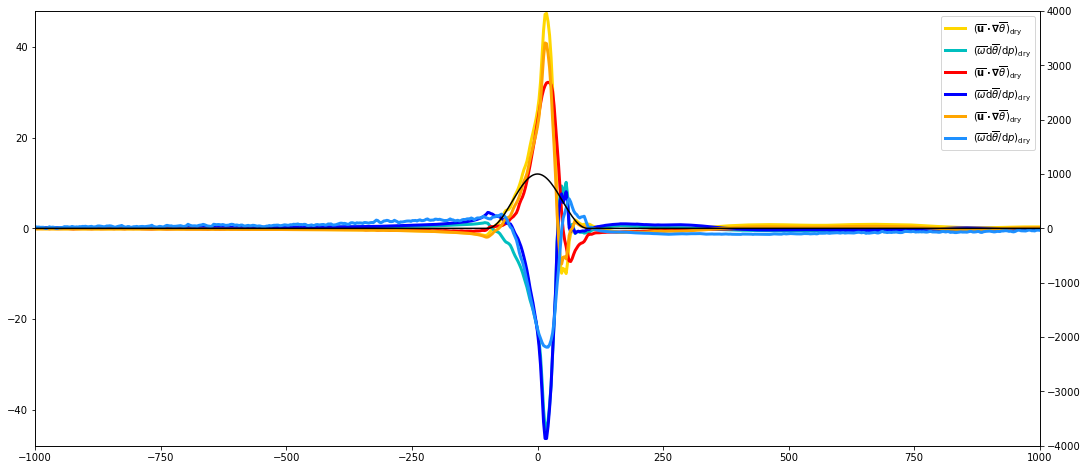

In [112]:
fig, ax = plt.subplots(1,1,figsize=(18,8))
ax2=ax.twinx()
ax2.plot(hrdist,hrhgt,color='k')


ax.plot(hrdist, dryudthetadx_p,linewidth=3,label=r"$(\mathbf{\overline{u} \cdot \nabla } \overline{\theta})_\mathrm{dry}$"         ,color="gold")
ax.plot(hrdist, dryomegadthetadp_p,linewidth=3,label=r"$(\overline{\omega} \mathrm{d}\overline{\theta}/\mathrm{d}p)_\mathrm{dry} $",color="c")

ax.plot(hrdist, udrydthetadx_p,linewidth=3,label=r"$(\mathbf{\overline{u} \cdot \nabla } \overline{\theta})_\mathrm{dry}$"         ,color="r")
ax.plot(hrdist, omegadrydthetadp_p,linewidth=3,label=r"$(\overline{\omega} \mathrm{d}\overline{\theta}/\mathrm{d}p)_\mathrm{dry} $",color="b")

ax.plot(hrdist, udthetadrydx_p,linewidth=3,label=r"$(\mathbf{\overline{u} \cdot \nabla } \overline{\theta})_\mathrm{dry}$"         ,color="orange")
ax.plot(hrdist, omegadthetadrydp_p,linewidth=3,label=r"$(\overline{\omega} \mathrm{d}\overline{\theta}/\mathrm{d}p)_\mathrm{dry} $",color="dodgerblue")


ax.set_xlim(-1000,1000)
ax.set_ylim(-48,48)
ax2.set_ylim(-4000,4000)
ax.legend()

In [39]:
rhomean_p = change_coords_pl(hrchannel_p,rhomean)[5:-4]
dryrhomean_p = change_coords_sfc(dryrhomean)[4:]

In [44]:
N = np.sqrt(-rhomean_p*9.81**2/thetamean_p * thetamean_p.differentiate('pressure')/100)
dryN = np.sqrt(-dryrhomean_p*9.81**2/drythetamean_p * drythetamean_p.differentiate('pressure')/100)

(-1000.0, 1000.0)

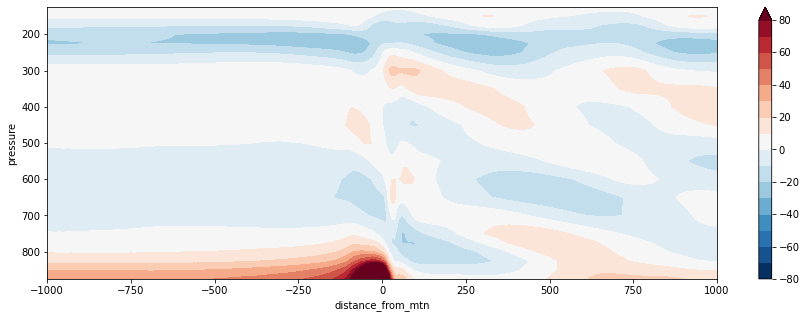

In [52]:
plt.figure(figsize=(15,5))
(100*(N-dryN)/dryN).plot.contourf(yincrease=False,levels=np.arange(-80,81,10))
plt.xlim(-1000,1000)

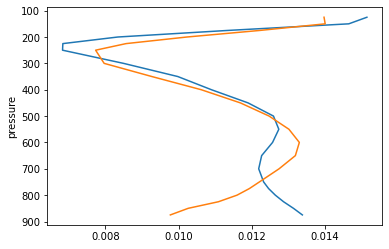

In [60]:
N[:,2000:3000].mean('distance_from_mtn').plot(y='pressure',yincrease=False)
dryN[:,2000:3000].mean('distance_from_mtn').plot(y='pressure',yincrease=False)

In [65]:
N[:,2000:3000].mean('distance_from_mtn').sel(pressure=slice(1000,250)).integrate('pressure')/(250-875)

<xarray.DataArray ()>
array(0.01161471)

In [66]:
dryN[:,2000:3000].mean('distance_from_mtn').sel(pressure=slice(1000,250)).integrate('pressure')/(250-875)

<xarray.DataArray ()>
array(0.01137381)

In [72]:
from scipy.signal import hilbert
from scipy.integrate import cumtrapz
import scipy.linalg as spl
def nonlinear_mountain_wave(h,N,U,x,z):
    """z must be two-dimensional here, dimensions=(eta_level,distance_from_mtn)"""
    z2=np.array(z).transpose()[::-1]
    f_L = -np.imag(hilbert(h))
    l=N/U
    H = h+1.j*f_L
    niter=20
    for i in range(niter):
        H = -1j*np.exp(-1j*l*h)*(np.imag(hilbert(np.real(H*np.exp(1j*l*h))))+1j*np.imag(hilbert(np.imag(H*np.exp(1j*l*h)))))
    f=np.imag(H)
    delta = h[:,None]*np.cos(l*(z2-h[:,None]))+f[:,None]*np.sin(l*(z2-h[:,None]))
    w=U*np.gradient(delta,x,axis=0)
    return xr.DataArray(w[::-1].transpose(),coords={'eta_level':z.eta_level,'distance_from_mtn':z.distance_from_mtn},dims={'eta_level','distance_from_mtn'})

def k_vector(Nx,dx):
    return 2*np.pi*np.fft.fftfreq(Nx,dx)

def m_exponent(k,N,U):
    return - np.sign(k**2-N**2/U**2)**((np.sign(k+1e-4*k[1])+1)/2) * np.sqrt(k**2-N**2/U**2+0.j) #1e-4*k[1] it there to avoid fractional powers

def linear_mountain_wave(h,N,U,x,z):
    k=k_vector(len(x),x[1]-x[0])
    h_hat = np.fft.fft(h)
    w_hat = 1j*k[:,None]*U*h_hat[:,None]*np.exp( m_exponent(k[:,None],N,U)  *  z[None,:]) 
    w=xr.DataArray(np.real(np.fft.ifft(w_hat,axis=0)),coords={'x':x,'z':z},dims={'x':x,'z':z})
    return w

In [68]:
U=10
N=0.0116
x = np.array(drywmean_s.distance_from_mtn)[::-1]
z=np.array(hrchannel.PHB[0,:,0,0]/9.81)

In [90]:
w_linear  = linear_mountain_wave(np.array(hrhgt[::-1]),N,U,1000*(x-x[0]),z)
w_linear_s=xr.DataArray(np.array(w_linear)[::-1].transpose(),coords={'eta_level':np.array(dryhrchannel.ZNW[0].load()),'distance_from_mtn':drywmean_s.distance_from_mtn},dims={'eta_level','distance_from_mtn'})

w_nonlinear_s = nonlinear_mountain_wave(np.array(hrhgt[::-1]),N,U,1000*(x-x[0]),change_coords_eta(hrchannel,hrchannel.PHB[0,:,0],staggered=True)/9.81)

w_linear_p = interp_eta_to_pressure(hrchannel,w_linear_s)
w_nonlinear_p = interp_eta_to_pressure(hrchannel,w_nonlinear_s)

wmean_p=change_coords_pl(hrchannel_p,wmean)[1:-4]
drywmean_p=change_coords_sfc(drywmean)

In [97]:
N=0.006
w_nonlinear_s = nonlinear_mountain_wave(np.array(hrhgt[::-1]),N,U,1000*(x-x[0]),change_coords_eta(hrchannel,hrchannel.PHB[0,:,0],staggered=True)/9.81)
w_nonlinear_p2 = interp_eta_to_pressure(hrchannel,w_nonlinear_s)


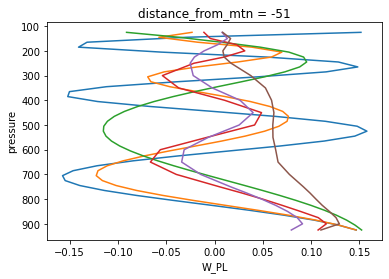

In [107]:
w_linear_p.sel(distance_from_mtn=-51).plot(y='pressure',yincrease=False)
w_nonlinear_p.sel(distance_from_mtn=-51).plot(y='pressure',yincrease=False)
w_nonlinear_p2.sel(distance_from_mtn=-51).plot(y='pressure',yincrease=False)

drywmean_p.sel(distance_from_mtn=-51).plot(y='pressure',yincrease=False)
wmean_p.sel(distance_from_mtn=-51).plot(y='pressure',yincrease=False)
wmean_p2.sel(distance_from_mtn=-51).plot(y='pressure',yincrease=False)


In [99]:
wmean_p2=hrchannel_p.W_PL[200:250].mean(['Time','south_north']).load()
wmean_p2=change_coords_pl(hrchannel_p,wmean_p2)[1:-4]

In [106]:
wmean_p2=wmean_p2.where(wmean_p2>-10)

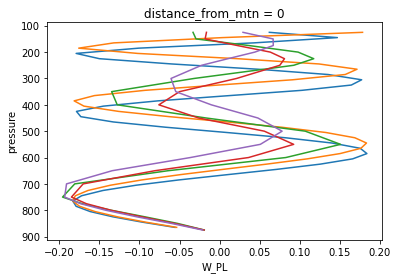

In [108]:
d=0
w_linear_p.sel(distance_from_mtn=d).plot(y='pressure',yincrease=False)
w_nonlinear_p.sel(distance_from_mtn=d).plot(y='pressure',yincrease=False)
drywmean_p.sel(distance_from_mtn=d).plot(y='pressure',yincrease=False)
wmean_p.sel(distance_from_mtn=d).plot(y='pressure',yincrease=False)
wmean_p2.sel(distance_from_mtn=d).plot(y='pressure',yincrease=False)


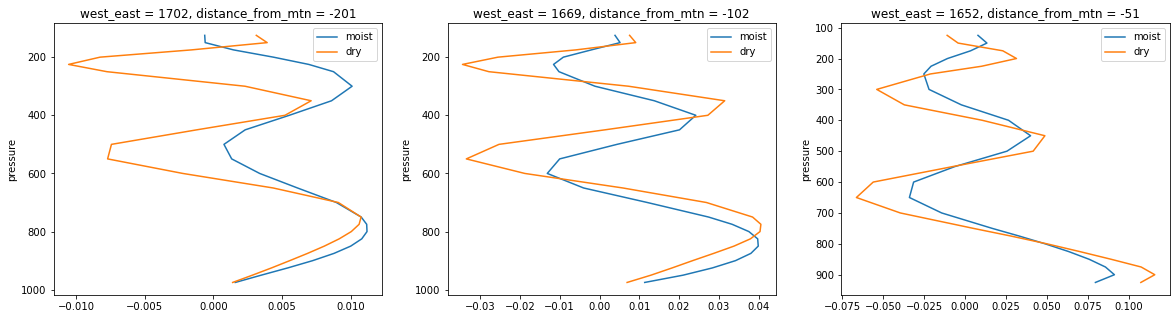

In [123]:
fig, axs = plt.subplots(1,3,figsize=(20,5))
wmean_p.sel(distance_from_mtn=-201).plot(ax=axs[0],y='pressure',yincrease=False,label='moist')
drywmean_p.sel(distance_from_mtn=-201).plot(ax=axs[0],y='pressure',yincrease=False,label='dry')

wmean_p.sel(distance_from_mtn=-102).plot(ax=axs[1],y='pressure',yincrease=False,label='moist')
drywmean_p.sel(distance_from_mtn=-102).plot(ax=axs[1],y='pressure',yincrease=False,label='dry')

wmean_p.sel(distance_from_mtn=-51).plot(ax=axs[2],y='pressure',yincrease=False,label='moist')
drywmean_p.sel(distance_from_mtn=-51).plot(ax=axs[2],y='pressure',yincrease=False,label='dry')
for a in axs:
    a.legend()

# Computing terms, then averaging

In [95]:
def select_timelon(ds):
    if 'west_east_stag' in ds.dims:
        return wrf.destagger(ds.isel(Time=slice(300,400)),3,meta=True).isel(west_east=slice(1135,2135))
    else:
        return ds.isel(Time=slice(300,400),west_east=slice(1135,2135))


In [88]:
plevs_875=np.arange(125.,880.,30.)

In [97]:
%%time
drytheta_sp = interp_pressure2(dryhrchannel.isel(west_east=slice(1135,2135)),select_timelon(dryhrchannel.T),plevs_875)
dryu_sp     = interp_pressure2(dryhrchannel.isel(west_east=slice(1135,2135)),select_timelon(dryhrchannel.U),plevs_875)
dryomega_sp = interp_pressure2(dryhrchannel.isel(west_east=slice(1135,2135)),-9.81*select_timelon(dryhrchannel.RHO)*wrf.destagger(select_timelon(dryhrchannel.W),1,meta=True),plevs_875)
dryudthetadx = (dryu_sp*drytheta_sp.differentiate('west_east')/3000 * 86400).integrate('pressure').mean(['south_north','Time'])/DeltaP
dryomegadthetadp = (dryomega_sp*drytheta_sp.differentiate('pressure')/100 * 86400).integrate('pressure').mean(['south_north','Time'])/DeltaP



CPU times: user 1min 3s, sys: 5min 43s, total: 6min 47s
Wall time: 7min 15s


In [96]:
%%time
theta_sp = interp_pressure2(hrchannel.isel(west_east=slice(1135,2135)),select_timelon(hrchannel.T),plevs_875)
u_sp     = interp_pressure2(hrchannel.isel(west_east=slice(1135,2135)),select_timelon(hrchannel.U),plevs_875)
omega_sp = interp_pressure2(hrchannel.isel(west_east=slice(1135,2135)),-9.81*select_timelon(hrchannel.RHO)*wrf.destagger(select_timelon(hrchannel.W),1,meta=True),plevs_875)
udthetadx = (u_sp*theta_sp.differentiate('west_east')/3000 * 86400).integrate('pressure').mean(['south_north','Time'])/DeltaP
omegadthetadp = (omega_sp*theta_sp.differentiate('pressure')/100 * 86400).integrate('pressure').mean(['south_north','Time'])/DeltaP



CPU times: user 1min 12s, sys: 2min 9s, total: 3min 22s
Wall time: 3min 40s


In [1]:
fig, ax = plt.subplots(1,1,figsize=(18,8))
ax2=ax.twinx()
ax2.plot(hrdist,hrhgt,color='k')

hrdist1000 = hrdist[1135:2135]
ax.plot(hrdist1000, dryudthetadx,linewidth=3,label=r"$(\mathbf{\overline{u} \cdot \nabla } \overline{\theta})_\mathrm{dry}$"     ,color="gold")
ax.plot(hrdist1000, dryomegadthetadp,linewidth=3,label=r"$(\mathbf{\overline{u} \cdot \nabla } \overline{\theta})_\mathrm{dry}$"     ,color="orange")

ax.plot(hrdist1000, udthetadx,linewidth=3    ,color="green")
ax.plot(hrdist1000, omegadthetadp,linewidth=3,color="b")


ax.set_xlim(-1000,1000)
ax.set_ylim(-48,48)
ax2.set_ylim(-4000,4000)
ax.legend()

NameError: name 'plt' is not defined

# Moisture budget test

In [17]:
def pressure_integ(ds):
    return -ds.fillna(0.).integrate('pressure')*100/9.81

mean3ugradQ = -(umean_p*qmean_p.differentiate('distance_from_mtn')/1000*86400).persist()
pmean3ugradQ= pressure_integ(mean3ugradQ )[1135:2135]

mean3omegadQdp = (omegamean_p*qmean_p.differentiate('pressure')/100.*86400).persist()
pmean3omegadQdp=pressure_integ(mean3omegadQdp )[1135:2135]


In [18]:
drywmean_s=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.W.days50-100.nc')
drywmean_p=interp_eta_to_pressure(dryhrchannel,change_coords_eta(dryhrchannel,drywmean_s,staggered=1),staggered=1,plevs=omegamean_p.pressure)
dryomegamean_p = -9.81*change_coords_pl(hrchannel_p,rhomean.where(rhomean >=0.)  )[1:-4]*drywmean_p

In [19]:
dryumean_s=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.U.days50-100.nc')
dryumean_p=interp_eta_to_pressure(dryhrchannel,change_coords_eta(dryhrchannel,wrf.destagger(dryumean_s,1,meta=True),staggered=0),staggered=0,plevs=omegamean_p.pressure)

In [20]:
drymean3ugradQ = (dryumean_p*qmean_p.differentiate('distance_from_mtn')/1000*86400).persist()
drypmean3ugradQ= pressure_integ(drymean3ugradQ )[1135:2135]

drymean3omegadQdp = (dryomegamean_p*qmean_p.differentiate('pressure')/100.*86400).persist()
drypmean3omegadQdp=pressure_integ(drymean3omegadQdp )[1135:2135]


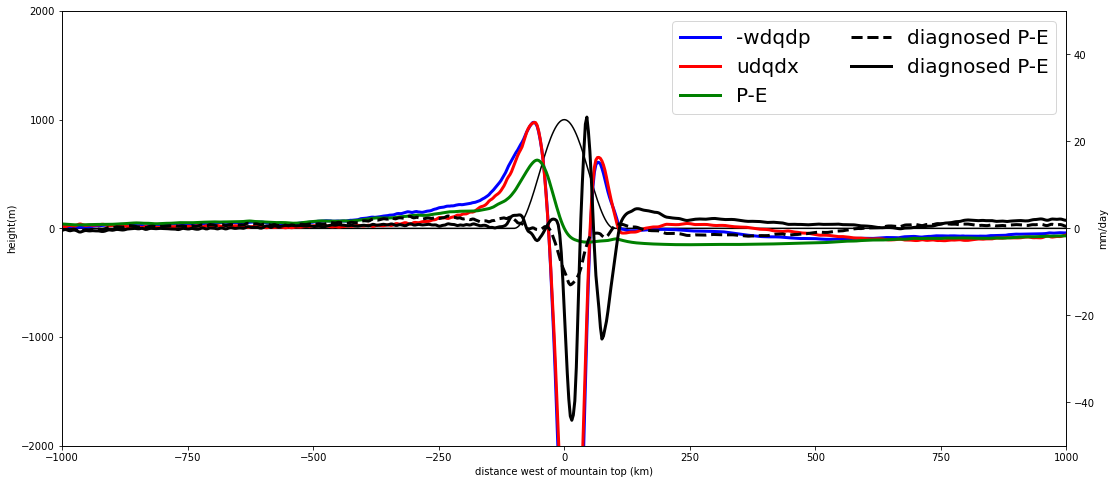

In [28]:
dist=drypmean3ugradQ.distance_from_mtn

fig, ax = plt.subplots(1,1,figsize=(18,8))
ax2=ax.twinx()

ax.plot(dist,hrhgt[1135:2135],color='k')

ax2.plot(dist, -pmean3omegadQdp.rolling(distance_from_mtn=10,center=True).mean(),linewidth=3,label="-wdqdp",color="blue")
ax2.plot(dist, pmean3ugradQ.rolling(distance_from_mtn=10,center=True).mean(),linewidth=3,label="udqdx",color="red")

#ax2.plot(dist, -drypmean3omegadQdp.rolling(distance_from_mtn=10,center=True).mean(),linewidth=3,label="-wdqdp",color="blue")
#ax2.plot(dist, drypmean3ugradQ.rolling(distance_from_mtn=10,center=True).mean(),linewidth=3,label="udqdx",color="red")


(hrpr-4).plot(ax=ax2,linewidth=3,label="P-E",color="g")
ax2.plot(dist, (-pmean3omegadQdp-pmean3ugradQ).rolling(distance_from_mtn=10,center=True).mean(),linewidth=3,label="diagnosed P-E",color="k",linestyle='--')
ax2.plot(dist, (-drypmean3omegadQdp-drypmean3ugradQ).rolling(distance_from_mtn=10,center=True).mean(),linewidth=3,label="diagnosed P-E",color="k")


ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-2000,2000)
ax.set_xlim(-1000,1000)
ax.set_yticks(range(-2000,2001,1000))

ax2.set_ylabel("mm/day")
ax2.set_ylim(-50,50)
ax2.set_yticks(range(-40,41,20))
ax2.legend(loc=1,ncol=2,fontsize=20)

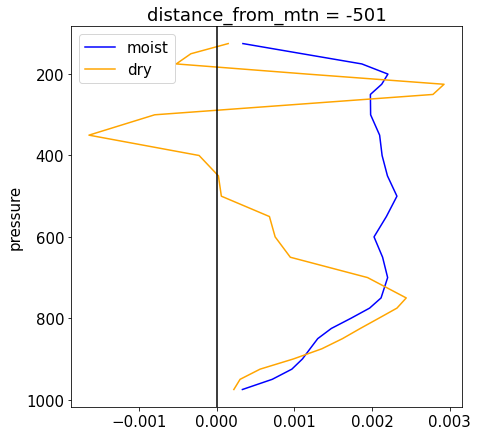

In [105]:
plt.figure(figsize=(7,7))
d=-500
wmean_p.sel(distance_from_mtn=d,method='nearest').plot(y='pressure',yincrease=False,color='blue',label='moist')
drywmean_p.sel(distance_from_mtn=d,method='nearest').plot(y='pressure',yincrease=False,color='orange',label='dry')
plt.axvline(0.,color='k')
plt.legend()

## Computing as a moisture convergence

In [11]:
def select_timeshort(ds):
    return ds.isel(Time=slice(600,700))

In [12]:
%%time

# Advective term
meanQ = change_coords_etav(hrchannel,select_timeshort(hrchannel.QVAPOR))
meandestag_U = change_coords_etav(hrchannel,wrf.destagger(select_timeshort(hrchannel.U),3,meta=True))
meanshortprecip = change_coords_sfc(select_timeshort(hrchannelprecip).mean(['Time','south_north']))
meanE = 86400*change_coords_sfc(select_timeshort(hrchannel.QFX).mean(['Time','south_north']))

CPU times: user 4.92 s, sys: 14.3 s, total: 19.2 s
Wall time: 31.3 s


In [13]:
full_eta=hrchannel.ZNW.isel(Time=-1)
eta=hrchannel.ZNU.isel(Time=-1).load()
deta=xr.DataArray(-np.diff(full_eta),coords={'eta_level':np.array(eta)},dims=['eta_level']).load()
dpdeta = xr.DataArray(np.gradient(hrchannel.PB[-1,:,0,:],hrchannel.ZNU.isel(Time=-1),axis=0, edge_order=2),coords={'eta_level':np.array(eta),'west_east':hrchannel.west_east},dims=['eta_level','west_east'])

In [14]:
%%time
moisture_divergence=((meandestag_U*meanQ*deta*dpdeta).sum('eta_level').differentiate('west_east')/3000).mean(['south_north','Time']).load()/9.81*86400

CPU times: user 13.1 s, sys: 6.63 s, total: 19.7 s
Wall time: 13 s


In [15]:
%%time
moisture_storage=(((meanQ*deta*dpdeta)[-1].sum('eta_level')-(meanQ*deta*dpdeta)[0].sum('eta_level'))/((meanQ.Time[-1]-meanQ.Time[0])/4)/9.81).mean('south_north').load()

CPU times: user 392 ms, sys: 502 ms, total: 894 ms
Wall time: 806 ms


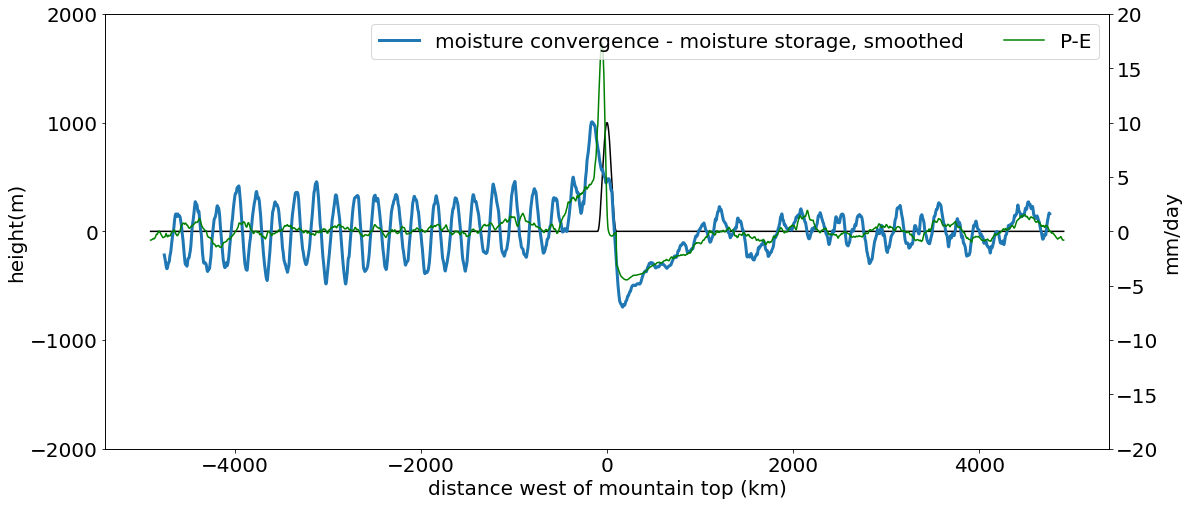

In [76]:
matplotlib.rcParams.update({'font.size':20})
dist=(1635-moisture_divergence.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(18,8))
ax2=ax.twinx()

ax.plot(dist,hrhgt,color='k')

#ax2.plot(dist, -moisture_divergence.rolling(west_east=100,center=True).mean()    ,linewidth=3,label=r"$-\nabla \int uq \, dp$")
#ax2.plot(dist, moisture_storage.rolling(west_east=100,center=True).mean()    ,linewidth=3,label=r"$d/dt \int q \, dp$")
ax2.plot(dist, (-moisture_divergence-moisture_storage).rolling(west_east=100,center=True).mean()    ,linewidth=3,label=r"moisture convergence - moisture storage, smoothed")

(meanshortprecip-meanE).plot(ax=ax2,color='g',label='P-E')

ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-2000,2000)
ax2.set_ylim(-20,20)
#ax.set_xlim(-1000,1000)
ax.set_yticks(range(-2000,2001,1000))

ax2.set_ylabel("mm/day")
#ax2.set_ylim(-42,42)
#ax2.set_yticks(range(-40,41,20))
ax2.legend(loc=1,ncol=2,fontsize=20)

In [27]:
umean_s   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.U.days50-200.nc')
qmean_s   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.QVAPOR.days50-200.nc')
umean_s = change_coords_etav(hrchannel,wrf.destagger(umean_s,1,meta=True))
qmean_s = change_coords_etav(hrchannel,qmean_s)
     

In [69]:
dryumean_s  = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.U.days50-100.nc')
dryumean_s = change_coords_etav(dryhrchannel,wrf.destagger(dryumean_s,1,meta=True))


In [30]:
%%time
moisture_divergence_mean=((umean_s*qmean_s*deta*dpdeta).sum('eta_level').differentiate('west_east')/3000)/9.81*86400

CPU times: user 7.87 ms, sys: 0 ns, total: 7.87 ms
Wall time: 6.63 ms


In [72]:
%%time
moisture_divergence_mean2=((-10*qmean_s*deta*dpdeta).sum('eta_level').differentiate('west_east')/3000)/9.81*86400

CPU times: user 11.6 ms, sys: 0 ns, total: 11.6 ms
Wall time: 10.1 ms


In [70]:
%%time
drymoisture_divergence_mean=((dryumean_s*qmean_s*deta*dpdeta).sum('eta_level').differentiate('west_east')/3000)/9.81*86400

CPU times: user 4.53 ms, sys: 4.57 ms, total: 9.11 ms
Wall time: 7.76 ms


(-500.0, 500.0)

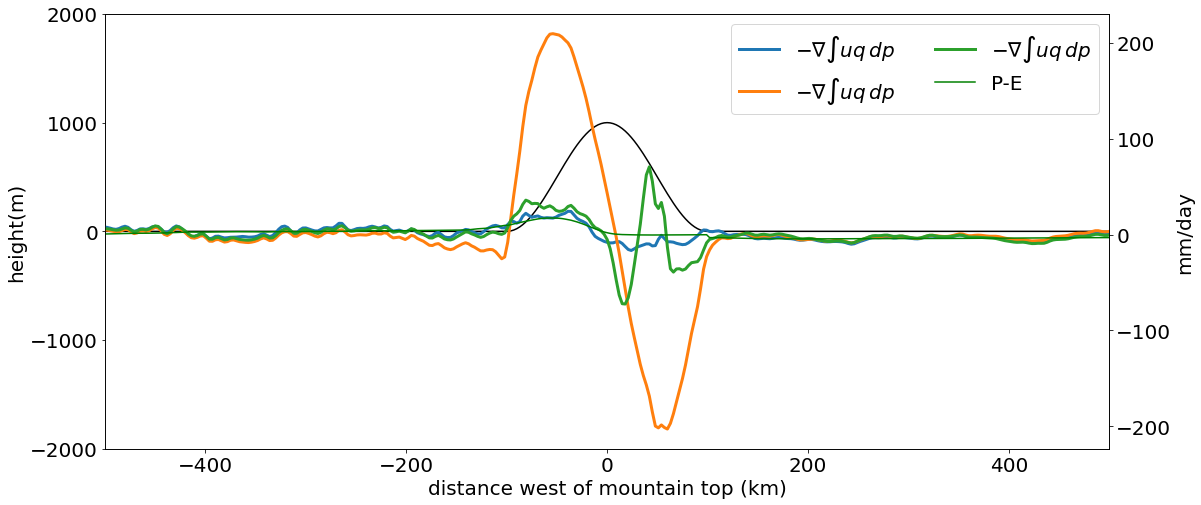

In [75]:
matplotlib.rcParams.update({'font.size':20})
dist=(1635-moisture_divergence.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(18,8))
ax2=ax.twinx()

ax.plot(dist,hrhgt,color='k')

ax2.plot(dist, -moisture_divergence_mean.rolling(west_east=2,center=True).mean()    ,linewidth=3,label=r"$-\nabla \int uq \, dp$")#
ax2.plot(dist, -moisture_divergence_mean2.rolling(west_east=2,center=True).mean()    ,linewidth=3,label=r"$-\nabla \int uq \, dp$")#

ax2.plot(dist, -drymoisture_divergence_mean.rolling(west_east=2,center=True).mean()    ,linewidth=3,label=r"$-\nabla \int uq \, dp$")#


#ax2.plot(dist, -moisture_divergence_mean2.rolling(west_east=100,center=True).mean()    ,linewidth=3,label=r"$-\nabla \int uq \, dp$")#

(meanshortprecip-meanE).plot(ax=ax2,color='g',label='P-E')

ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-2000,2000)
#ax2.set_ylim(-30,30)
#ax.set_xlim(-1000,1000)
ax.set_yticks(range(-2000,2001,1000))

ax2.set_ylabel("mm/day")
#ax2.set_ylim(-42,42)
#ax2.set_yticks(range(-40,41,20))
ax2.legend(loc=1,ncol=2,fontsize=20)

ax2.axvline(-1970)
ax2.axvline(-2180)
ax.set_xlim(-500,500)

In [84]:
%%time
qmean_s2   = hrchannel.QVAPOR[-100::4].mean(['Time','south_north'])
qmean_s2 = change_coords_etav(hrchannel,qmean_s2)


CPU times: user 27.6 s, sys: 2.44 s, total: 30 s
Wall time: 30 s


In [45]:
%%time
pw_mean=((qmean_s*deta*dpdeta).sum('eta_level'))/9.81

CPU times: user 9.29 ms, sys: 2.09 ms, total: 11.4 ms
Wall time: 9.86 ms


In [85]:
pw_mean2=((qmean_s2*deta*dpdeta).sum('eta_level'))/9.81

In [57]:
pw_p_mean=-qmean_p.integrate('pressure')*100/9.81

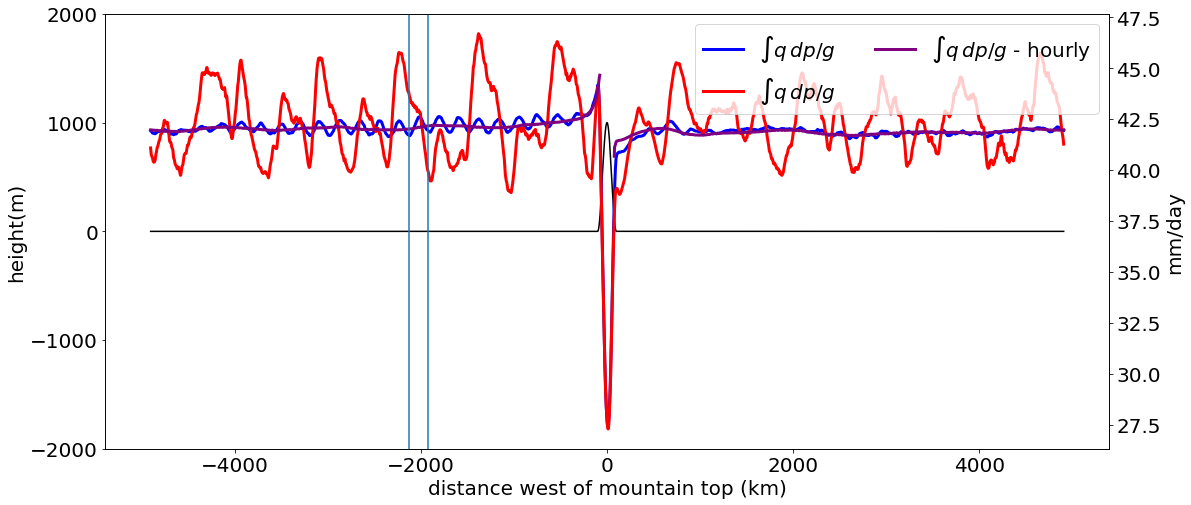

In [86]:
matplotlib.rcParams.update({'font.size':20})
dist=(1635-moisture_divergence.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(18,8))
ax2=ax.twinx()

ax.plot(dist,hrhgt,color='k')

ax2.plot(dist, pw_mean    ,linewidth=3,label=r"$\int q \, dp/g$",color='b')#
ax2.plot(dist, pw_mean2    ,linewidth=3,label=r"$\int q \, dp/g$",color='r')#

ax2.plot(dist, 3.8+pw_p_mean    ,linewidth=3,label=r"$\int q \, dp/g$ - hourly",color='purple')#


ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-2000,2000)
#ax2.set_ylim(-20,20)
#ax.set_xlim(-1000,1000)
ax.set_yticks(range(-2000,2001,1000))

ax2.set_ylabel("mm/day")
#ax2.set_ylim(-42,42)
#ax2.set_yticks(range(-40,41,20))
ax2.legend(loc=1,ncol=2,fontsize=20)

ax2.axvline(-1920)
ax2.axvline(-2130)

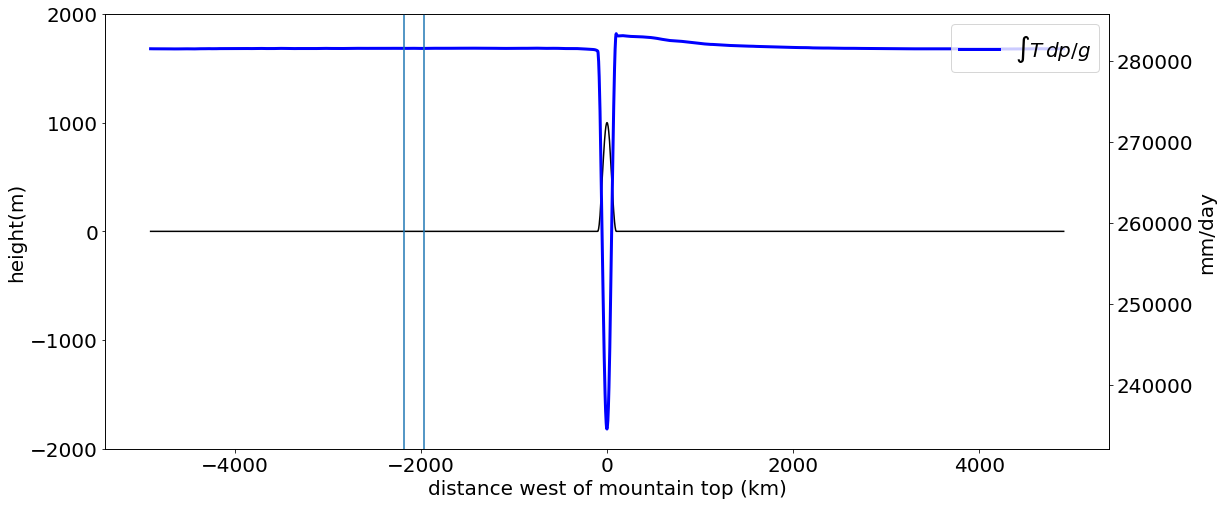

In [60]:
tmean_s   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.TEMP.days50-200.nc')
tmean_s = change_coords_etav(hrchannel,tmean_s)

tinteg=((tmean_s*deta*dpdeta)[:4].sum('eta_level'))/9.81
     
matplotlib.rcParams.update({'font.size':20})
dist=(1635-moisture_divergence.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(18,8))
ax2=ax.twinx()

ax.plot(dist,hrhgt,color='k')

ax2.plot(dist, tinteg    ,linewidth=3,label=r"$\int T \, dp/g$",color='b')#

ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-2000,2000)
#ax2.set_ylim(-20,20)
#ax.set_xlim(-1000,1000)
ax.set_yticks(range(-2000,2001,1000))

ax2.set_ylabel("mm/day")
#ax2.set_ylim(-42,42)
#ax2.set_yticks(range(-40,41,20))
ax2.legend(loc=1,ncol=2,fontsize=20)

ax2.axvline(-1970)
ax2.axvline(-2180)

## last try

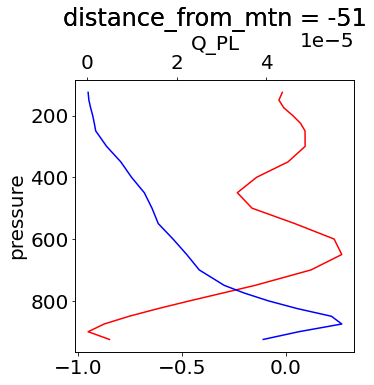

In [96]:
omegamtn=omegamean_p.sel(distance_from_mtn=-50,method='nearest')[2:]
qmtn=qmean_p.sel(distance_from_mtn=-50,method='nearest')[2:]

plt.figure(figsize=(5,5))
omegamtn.plot(y='pressure',yincrease=False,color='r')
plt.twiny()
qmtn.differentiate('pressure').plot(y='pressure',yincrease=False,color='b')

In [15]:
drywmean_s=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.W.days50-100.nc')
drywmean_p=interp_eta_to_pressure(dryhrchannel,change_coords_eta(dryhrchannel,drywmean_s,staggered=1),staggered=1,plevs=omegamean_p.pressure)

In [16]:
dryomegamean_p = -9.81*change_coords_pl(hrchannel_p,rhomean.where(rhomean >=0.)  )[1:-4]*drywmean_p

In [71]:
pr_test=(omegamean_p*qmean_p.differentiate('pressure')).fillna(0.).integrate('pressure')/9.81*86400
drypr_test=(dryomegamean_p*qmean_p.differentiate('pressure')).fillna(0.).integrate('pressure')/9.81*86400

In [33]:
pr_test_zeroed=(np.minimum(0.,omegamean_p*qmean_p.differentiate('pressure'))[4:]).integrate('pressure')/9.81*86400
drypr_test_zeroed=(np.minimum(0.,dryomegamean_p*qmean_p.differentiate('pressure'))[4:]).integrate('pressure')/9.81*86400

In [27]:
hrpr=change_coords_sfc(hrchannelprecip[200:].mean(['Time','south_north'])).load()

Text(0, 0.5, 'mm/day')

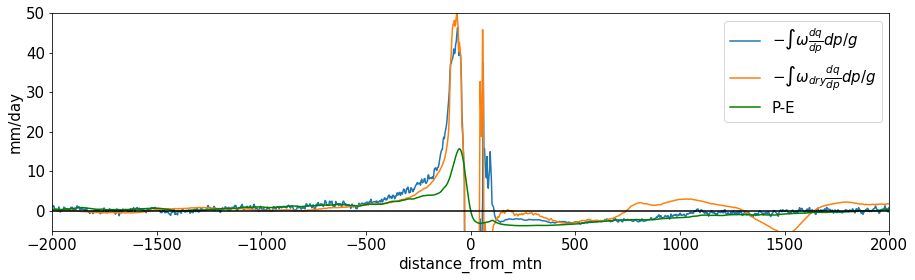

In [72]:
matplotlib.rcParams.update({'font.size':15})

plt.figure(figsize=(15,4))
pr_test.plot(label=r"$- \int \omega \frac{dq}{dp} dp/g$")
drypr_test.plot(label=r"$- \int \omega_{dry} \frac{dq}{dp} dp/g$")
(hrpr-4).plot(color='g',label='P-E')


plt.legend()
plt.axhline(0.,color='k')
plt.xlim(-2000,2000)
plt.ylim(-5,50)
plt.ylabel("mm/day")

# Pressure interpolation of dry variables

In [115]:
plevs=np.array(hrchannel_p.P_PL.isel(Time=0).load())[1:-4]/100

In [116]:
files = ['/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/wrfout_d01_1970-02-20_06_00_00',
                '/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/wrfout_d01_1970-03-02_06_00_00',
                '/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/wrfout_d01_1970-03-12_06_00_00',
                '/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/wrfout_d01_1970-03-22_06_00_00',
                '/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/wrfout_d01_1970-04-01_06_00_00']
dlist=[Dataset(file) for file in files]

In [117]:
dryt_s = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.TEMP.all.days50-100.nc')[1:]

In [64]:
%%time
out = xr.DataArray(np.zeros((200,len(plevs),len(hrchannel.south_north),len(hrchannel.west_east))),coords={'Time':dryt_s.Time,'pressure':plevs[::-1],'south_north':dryt_s.south_north,'west_east':dryt_s.west_east},dims=['Time','pressure','south_north','west_east'])
for i in range(len(dryt_s.Time)):
    out[i]= wrf.vinterp(dlist[i//40],
                        dryt_s[i],"pressure",plevs,timeidx=i%40
                       ).rename({'interp_level':'pressure'})[::-1]

CPU times: user 5min, sys: 2min 35s, total: 7min 36s
Wall time: 9min 12s


In [11]:
dryu_s = dryhrchannel.U[201:]

In [12]:
%%time
out = xr.DataArray(np.zeros((200,len(plevs),len(hrchannel.south_north),len(hrchannel.west_east))),coords={'Time':dryt_s.Time,'pressure':plevs[::-1],'south_north':dryt_s.south_north,'west_east':dryt_s.west_east},dims=['Time','pressure','south_north','west_east'])
for i in range(len(dryt_s.Time)):
    out[i]= wrf.vinterp(dlist[i//40],
                        wrf.destagger(dryu_s[i],2,meta=True),"pressure",plevs,timeidx=i%40
                       ).rename({'interp_level':'pressure'})[::-1]
out.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.U_PL.all.days50-100.nc')

CPU times: user 5min 20s, sys: 2min 40s, total: 8min 1s
Wall time: 9min 8s


In [16]:
dryw_s = dryhrchannel.W[201:]

In [17]:
%%time
out = xr.DataArray(np.zeros((200,len(plevs),len(hrchannel.south_north),len(hrchannel.west_east))),coords={'Time':dryt_s.Time,'pressure':plevs[::-1],'south_north':dryt_s.south_north,'west_east':dryt_s.west_east},dims=['Time','pressure','south_north','west_east'])
for i in range(len(dryt_s.Time)):
    out[i]= wrf.vinterp(dlist[i//40],
                        wrf.destagger(dryw_s[i],0,meta=True),"pressure",plevs,timeidx=i%40
                       ).rename({'interp_level':'pressure'})[::-1]
out.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.W_PL.all.days50-100.nc')

CPU times: user 5min 17s, sys: 3min 1s, total: 8min 19s
Wall time: 8min 58s


In [18]:
dryrho_s = dryhrchannel.RHO[201:]

In [19]:
%%time
out = xr.DataArray(np.zeros((200,len(plevs),len(hrchannel.south_north),len(hrchannel.west_east))),coords={'Time':dryt_s.Time,'pressure':plevs[::-1],'south_north':dryt_s.south_north,'west_east':dryt_s.west_east},dims=['Time','pressure','south_north','west_east'])
for i in range(len(dryt_s.Time)):
    out[i]= wrf.vinterp(dlist[i//40],
                        dryrho_s[i],"pressure",plevs,timeidx=i%40
                       ).rename({'interp_level':'pressure'})[::-1]
out.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.RHO_PL.all.days50-100.nc')



CPU times: user 5min 12s, sys: 2min 52s, total: 8min 5s
Wall time: 8min 50s


In [20]:
out.mean(['Time','south_north']).to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.RHO_PL.days50-100.nc')

In [21]:
xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.W_PL.all.days50-100.nc').mean(['Time','south_north']).to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.W_PL.days50-100.nc')

In [22]:
xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.U_PL.all.days50-100.nc').mean(['Time','south_north']).to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.U_PL.days50-100.nc')

In [23]:
xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.T_PL.all.days50-100.nc').mean(['Time','south_north']).to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.T_PL.days50-100.nc')


In [113]:
dryq_s = dryhrchannel.QVAPOR[201:]

In [118]:
%%time
out = xr.DataArray(np.zeros((200,len(plevs),len(hrchannel.south_north),len(hrchannel.west_east))),coords={'Time':dryt_s.Time,'pressure':plevs[::-1],'south_north':dryt_s.south_north,'west_east':dryt_s.west_east},dims=['Time','pressure','south_north','west_east'])
for i in range(len(dryt_s.Time)):
    out[i]= wrf.vinterp(dlist[i//40],
                        dryq_s[i],"pressure",plevs,timeidx=i%40
                       ).rename({'interp_level':'pressure'})[::-1]
out.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.Q_PL.all.days50-100.nc')



CPU times: user 5min 10s, sys: 2min 34s, total: 7min 45s
Wall time: 8min 50s


In [119]:
out.mean(['Time','south_north']).to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.Q_PL.days50-100.nc')